In [153]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import re
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
import pickle
import warnings
warnings.filterwarnings('ignore')

In [80]:
# Read the data from input

df = pd.read_csv('train.csv')
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Any results you write to the current directory are saved as output.
df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [81]:
df.shape[0] - df.dropna().shape[0]

64448

In [82]:
df.loc[:,['site_eui', 'energy_star_rating', 'floor_area', 'year_built', 'ELEVATION', 
          'Year_Factor', 'State_Factor']].describe()

,site_eui,energy_star_rating,floor_area,year_built,ELEVATION,Year_Factor
count,75757.000000,49048.000000,7.575700e+04,73920.000000,75757.000000,75757.000000
mean,82.584693,61.048605,1.659839e+05,1952.306764,39.506323,4.367755
std,58.255403,28.663683,2.468758e+05,37.053619,60.656596,1.471441
min,1.001169,0.000000,9.430000e+02,0.000000,-6.400000,1.000000
25%,54.528601,40.000000,6.237900e+04,1927.000000,11.900000,3.000000
50%,75.293716,67.000000,9.136700e+04,1951.000000,25.000000,5.000000
75%,97.277534,85.000000,1.660000e+05,1977.000000,42.700000,6.000000
max,997.866120,100.000000,6.385382e+06,2015.000000,1924.500000,6.000000


### Check Data Types

In [83]:
print(df.dtypes)

Year_Factor                    int64
State_Factor                  object
building_class                object
facility_type                 object
floor_area                   float64
                              ...   
direction_peak_wind_speed    float64
max_wind_speed               float64
days_with_fog                float64
site_eui                     float64
id                             int64
Length: 64, dtype: object


In [84]:
df.drop(["id",'Year_Factor'], axis=1, inplace=True)

In [85]:
df.shape

(75757, 62)

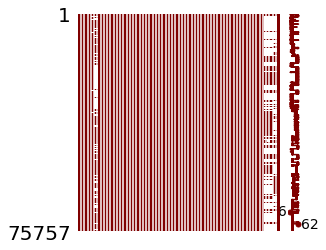

In [86]:
# search for missing data
import missingno as msno
msno.matrix(df, figsize=(4,4), color=(0.5,0,0))

### Drop Duplicate rows

In [87]:
df.drop_duplicates(inplace=True)
df.shape

(75718, 62)

### Filling the missing data with the median value and droping feature columns with lots of missing data

### Visualize all the missing data, the white lines are missing values

In [88]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df[missing_value_df.percent_missing != 0.0]

,column_name,percent_missing
year_built,year_built,2.399694
energy_star_rating,energy_star_rating,35.238649
direction_max_wind_speed,direction_max_wind_speed,54.240735
direction_peak_wind_speed,direction_peak_wind_speed,55.202198
max_wind_speed,max_wind_speed,54.240735
days_with_fog,days_with_fog,60.465147


In [89]:
col_high_missing = ['direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
df = df.drop(col_high_missing,1)
df

,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,248.682615
1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,3.899395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,132.918411
75753,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,39.483672
75754,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,26,36.612903,48,...,47.911202,26,2,0,0,6,0,0,0,48.404398
75755,State_11,Commercial,Commercial_Other,53575.0,2012.0,NaN,36.6,26,36.612903,48,...,47.911202,26,2,0,0,6,0,0,0,592.022750


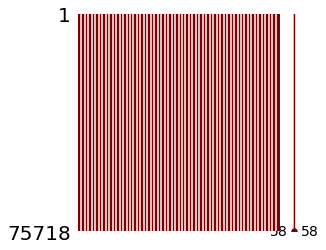

In [90]:
df = df.fillna(df.median())

# Visualize again
import missingno as msno
msno.matrix(df, figsize=(4,4), color=(0.5,0,0))

### Correlation Analysis

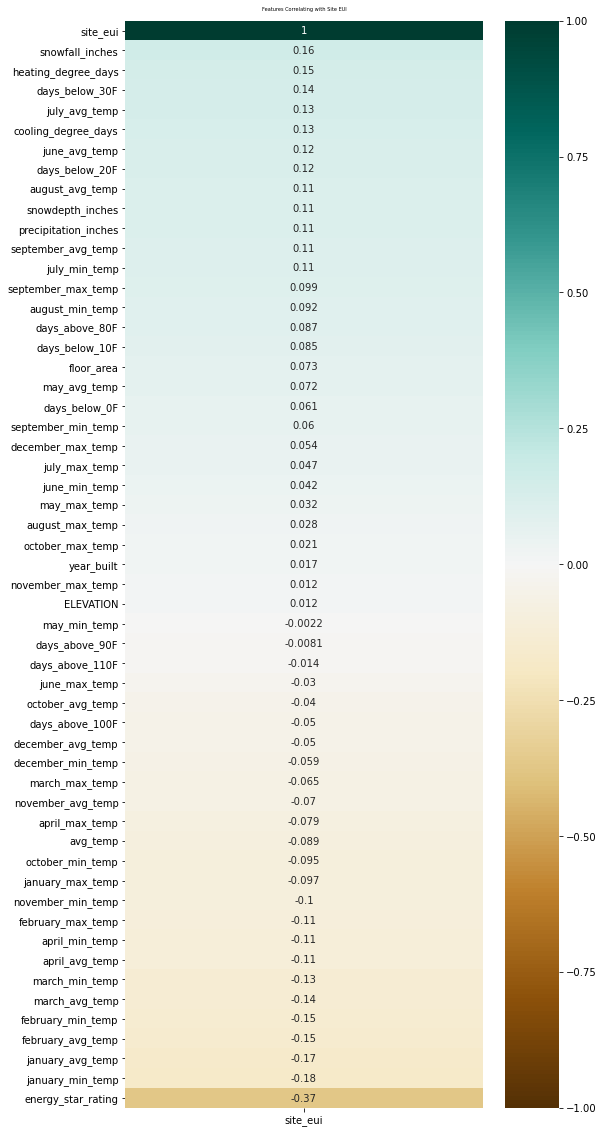

In [91]:
plt.figure(figsize=(8, 20))
heatmap = sns.heatmap(df.corr()[['site_eui']].sort_values(by='site_eui', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Site EUI', fontdict={'fontsize':5}, pad=10);

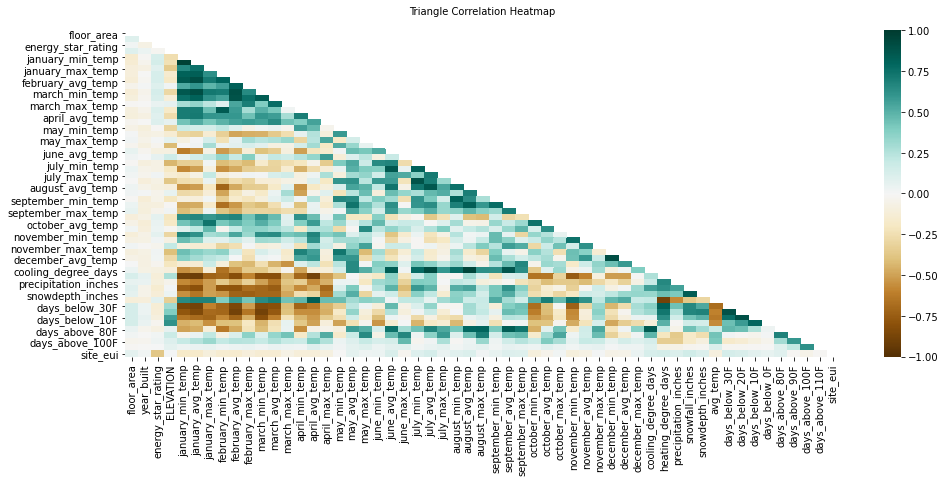

In [92]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':10}, pad=16);

In [93]:
def correlation(dataframe, threshold):
    high_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataframe.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and ((corr_matrix.columns[j], corr_matrix.columns[i]) not in high_corr):
                columns = (corr_matrix.columns[i], corr_matrix.columns[j]) # getting the name of the columns
                high_corr.add(columns)

    return high_corr

high_corr = correlation(df, 0.95)
print(high_corr)

{('cooling_degree_days', 'august_avg_temp'), ('january_avg_temp', 'january_min_temp')}


In [94]:
df.drop(columns=['january_min_temp'], 
        axis=1, inplace=True)

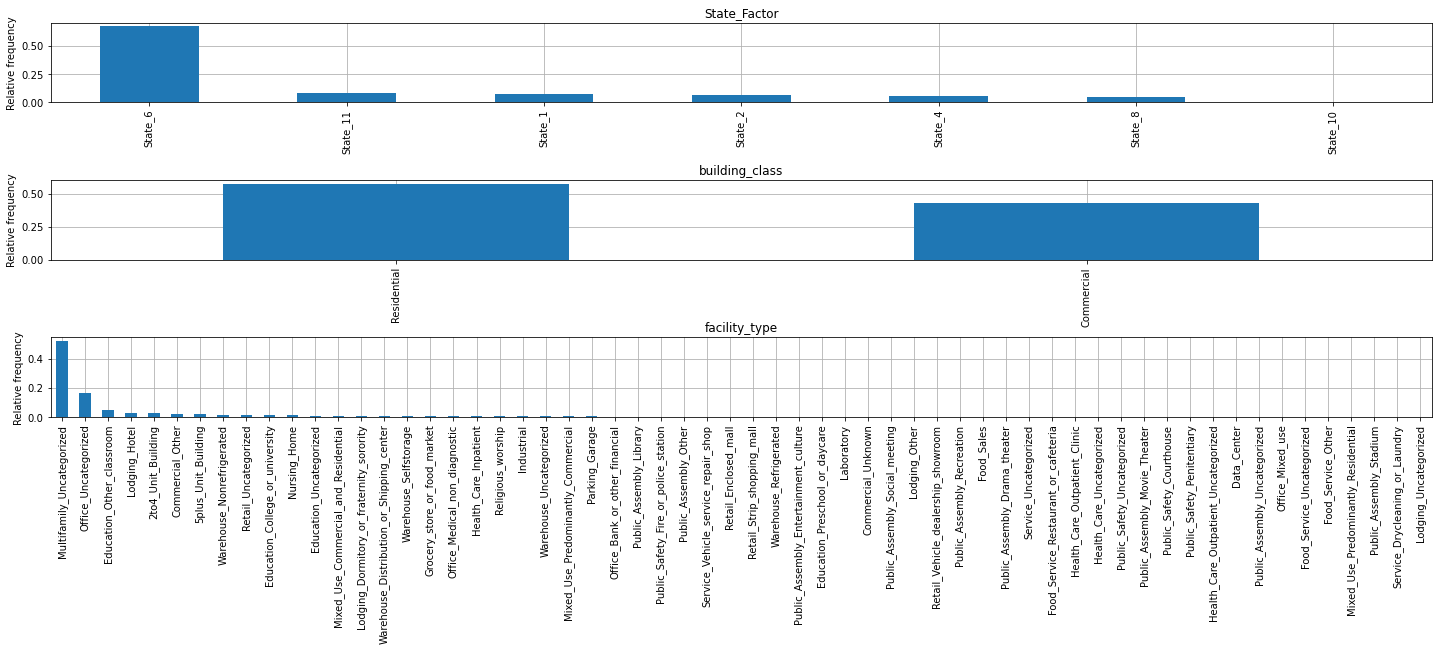

In [95]:
def plot_distbn(column, column_name, num):
    plt.subplot(num)
    column.value_counts(normalize=True).plot(kind='bar')
    plt.title(column_name)
    plt.ylabel('Relative frequency')
    plt.tight_layout()
    plt.grid(True)
    
    return column.value_counts(normalize=True)


plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(20,6))
rel_freqs1 = plot_distbn(df['State_Factor'], 'State_Factor', 311)
rel_freqs2 = plot_distbn(df['building_class'], 'building_class', 312)
rel_freqs3 = plot_distbn(df['facility_type'], 'facility_type', 313)

In [96]:
df = df.drop('State_Factor',1)

In [97]:
significant = rel_freqs3.index[:6].tolist()
print(significant)

['Multifamily_Uncategorized', 'Office_Uncategorized', 'Education_Other_classroom', 'Lodging_Hotel', '2to4_Unit_Building', 'Commercial_Other']


In [98]:
df['facility_type'].loc[~df['facility_type'].isin(significant)] = 'Others'
df['facility_type'].loc[~df['facility_type'].isin(significant)] = 'Others'
df.head()

,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,Commercial,Others,61242.0,1942.0,11.0,2.4,50.5,68,35,50.589286,...,56.972603,0,0,0,0,14,0,0,0,248.682615
1,Commercial,Others,274000.0,1955.0,45.0,1.8,50.5,68,35,50.589286,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,Commercial,Others,280025.0,1951.0,97.0,1.8,50.5,68,35,50.589286,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,50.5,68,35,50.589286,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,Commercial,Others,66000.0,1985.0,100.0,2.4,50.5,68,35,50.589286,...,56.972603,0,0,0,0,14,0,0,0,3.899395


In [99]:
for x in ['site_eui']:
    q75, q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
    
    ul = q75+(1.5*intr_qr)
    ll = q25-(1.5*intr_qr)
    
    df.loc[df[x]<ll,x] = np.nan
    df.loc[df[x]>ul,x] = np.nan

df['site_eui'].isnull().sum()

3845

In [100]:
df = df.dropna(axis = 0)

In [101]:
numeric = []
for col in df.columns:
    if df[col].dtype != 'object':
        numeric.append(col)

In [102]:
enc = OrdinalEncoder()

for col in df:
    if df[col].dtype =='object':
        df[col] = enc.fit_transform(df[col].values.reshape(-1,1))

Training done using Random Forest


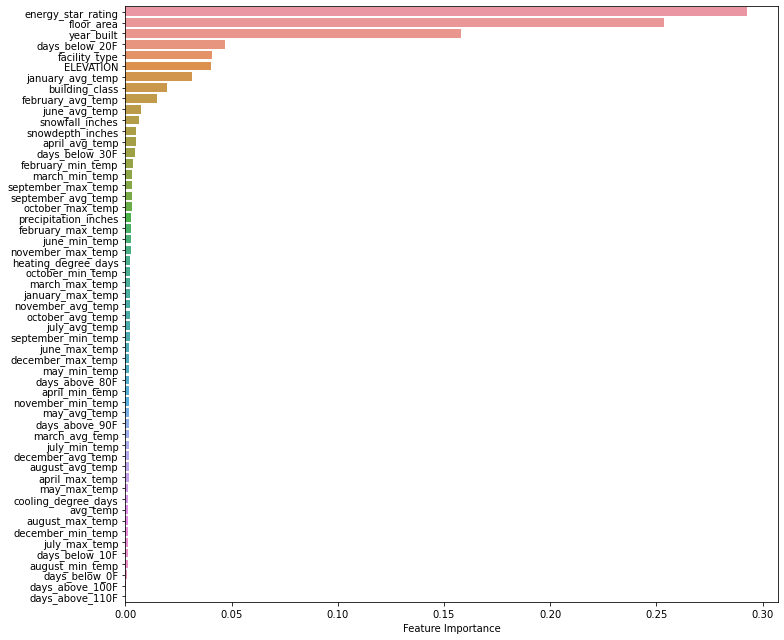

In [103]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(df.iloc[:,:-1], df['site_eui'])
print("Training done using Random Forest")

ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11,9))
sns.barplot(x=rf.feature_importances_[ranking], y=df.iloc[:,:-1].columns.values[ranking], orient='h')
ax.set_xlabel("Feature Importance")
plt.tight_layout()
plt.show()

In [104]:
df['SpringTemp'] = (df.march_avg_temp + df.april_avg_temp + df.may_avg_temp)/3
df['SummerTemp'] = (df.june_avg_temp + df.july_avg_temp + df.august_avg_temp)/3
df['FallTemp'] = (df.september_avg_temp + df.october_avg_temp + df.november_avg_temp)/3
df['WinterTemp'] = (df.december_avg_temp + df.january_avg_temp + df.february_avg_temp)/3

df['floorxBuilt'] = df.floor_area * df.year_built 
df['floorxEnergy'] = df.floor_area * df.energy_star_rating
df['floorxBuiltxEnergy'] = df.floor_area * df.year_built * df.energy_star_rating
df['floorxHeatCool'] = df.floor_area *(df.cooling_degree_days + df.heating_degree_days)

df["freezing_days"] = df.days_below_0F + df.days_below_10F
df["cold_days"] = df.days_below_20F + df.days_below_30F
df["warm_days"] = df.days_above_80F + df.days_above_90F
df["hot_days"] = df.days_above_100F + df.days_above_110F
    
df["floor_areaxenergy_star_rating"] = df.floor_area*df.energy_star_rating
df["floor_areaxELEVATION"] = df.floor_area*df.ELEVATION

df["snow_rain_inches"] = df.snowfall_inches + df.precipitation_inches

In [105]:
df = df.drop(['days_below_30F', 'days_below_20F', 'days_below_10F',
       'days_below_0F', 'days_above_80F', 'days_above_90F', 'days_above_100F',
       'days_above_110F','precipitation_inches', 'snowfall_inches', 'snowdepth_inches', 'january_avg_temp', 
         'january_max_temp', 'february_min_temp',
       'february_avg_temp', 'february_max_temp', 'march_min_temp',
       'march_avg_temp', 'march_max_temp', 'april_min_temp', 'april_avg_temp',
       'april_max_temp', 'may_min_temp', 'may_avg_temp', 'may_max_temp',
       'june_min_temp', 'june_avg_temp', 'june_max_temp', 'july_min_temp',
       'july_avg_temp', 'july_max_temp', 'august_min_temp', 'august_avg_temp',
       'august_max_temp', 'september_min_temp', 'september_avg_temp',
       'september_max_temp', 'october_min_temp', 'october_avg_temp',
       'october_max_temp', 'november_min_temp', 'november_avg_temp',
       'november_max_temp', 'december_min_temp', 'december_avg_temp',
       'december_max_temp', 'cooling_degree_days', 'heating_degree_days'],1)

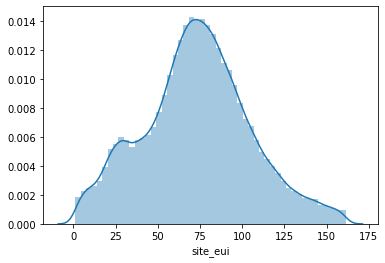

In [106]:
ax = sns.distplot(df['site_eui'])
plt.show()

In [107]:
df.columns

Index(['building_class', 'facility_type', 'floor_area', 'year_built',
       'energy_star_rating', 'ELEVATION', 'avg_temp', 'site_eui', 'SpringTemp',
       'SummerTemp', 'FallTemp', 'WinterTemp', 'floorxBuilt', 'floorxEnergy',
       'floorxBuiltxEnergy', 'floorxHeatCool', 'freezing_days', 'cold_days',
       'warm_days', 'hot_days', 'floor_areaxenergy_star_rating',
       'floor_areaxELEVATION', 'snow_rain_inches'],
      dtype='object')

In [108]:
df_t = df.copy()

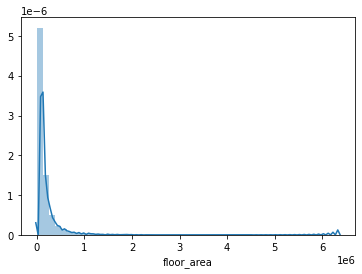

In [109]:
sns.distplot(df_t.drop('site_eui',1).floor_area)

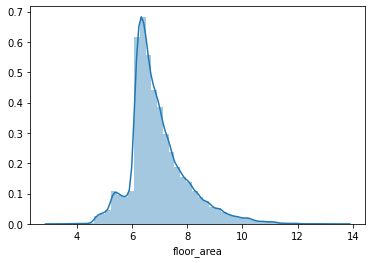

In [110]:
df_t.floor_area = (df_t.floor_area)**(1/6)
sns.distplot(df_t.floor_area)

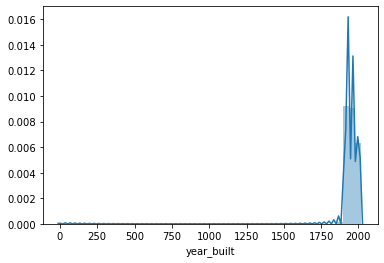

In [111]:
sns.distplot(df_t.year_built)

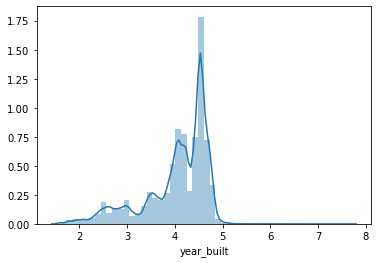

In [112]:
df_t.year_built = np.log(2020-df_t.year_built)
sns.distplot(df_t.year_built)

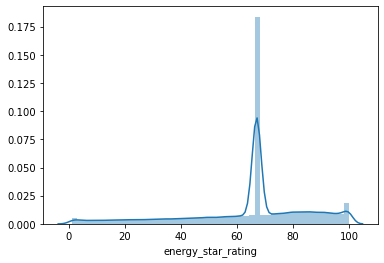

In [113]:
sns.distplot(df_t.energy_star_rating)

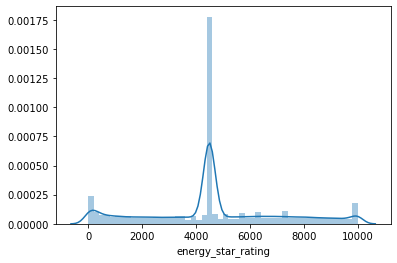

In [114]:
df_t.energy_star_rating = (df_t.energy_star_rating)**2
sns.distplot(df_t.energy_star_rating)

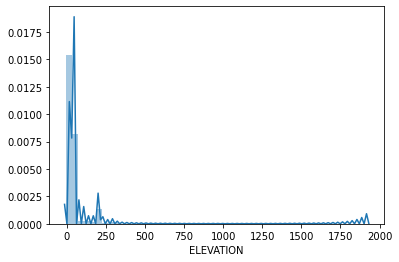

In [115]:
sns.distplot(df_t.ELEVATION)

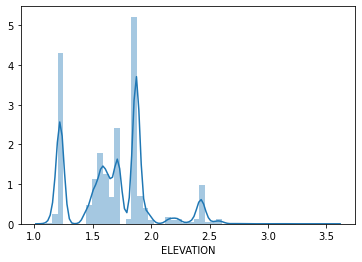

In [116]:
df_t.ELEVATION = (df_t.ELEVATION)**(1/6)
sns.distplot(df_t.ELEVATION)

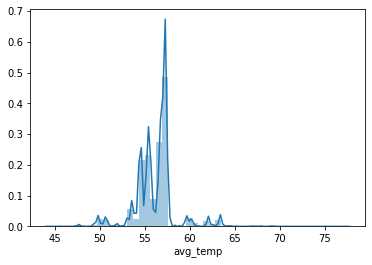

In [117]:
sns.distplot(df_t.avg_temp)

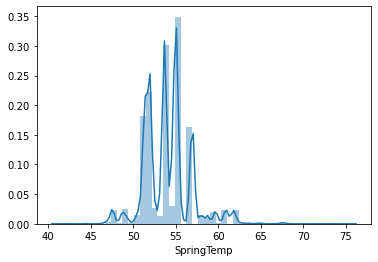

In [118]:
sns.distplot(df_t.SpringTemp)

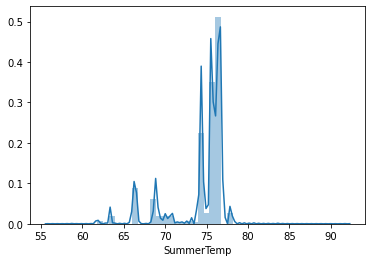

In [119]:
sns.distplot(df_t.SummerTemp)

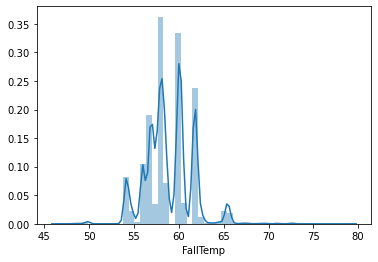

In [120]:
sns.distplot(df_t.FallTemp)

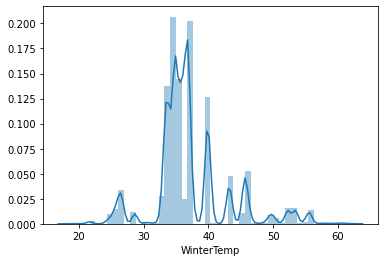

In [121]:
sns.distplot(df_t.WinterTemp)

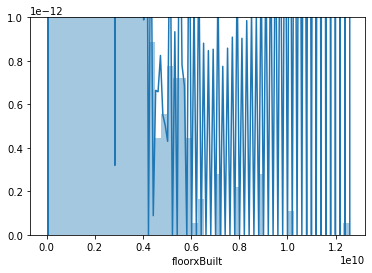

In [122]:
sns.distplot(df_t.floorxBuilt)

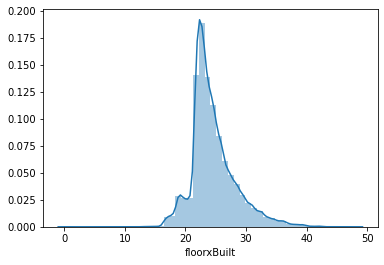

In [123]:
df_t.floorxBuilt = (df_t.floorxBuilt)**(1/6)
sns.distplot(df_t.floorxBuilt)

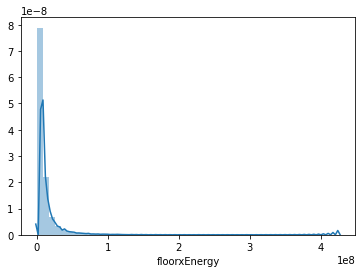

In [124]:
sns.distplot(df_t.floorxEnergy)

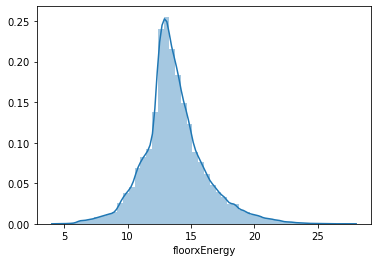

In [125]:
df_t.floorxEnergy = (df_t.floorxEnergy)**(1/6)
sns.distplot(df_t.floorxEnergy)

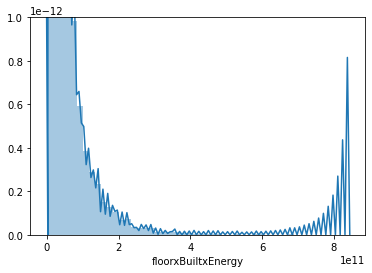

In [126]:
sns.distplot(df_t.floorxBuiltxEnergy)

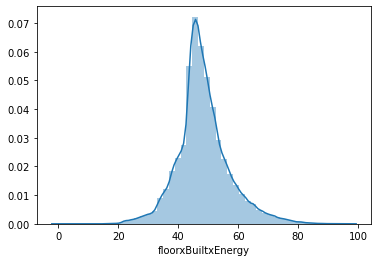

In [127]:
df_t.floorxBuiltxEnergy = (df_t.floorxBuiltxEnergy)**(1/6)
sns.distplot(df_t.floorxBuiltxEnergy)

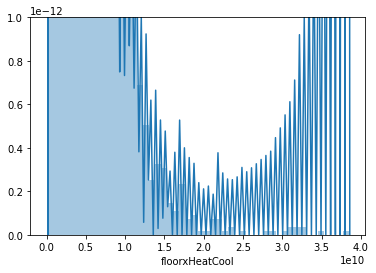

In [128]:
sns.distplot(df_t.floorxHeatCool)

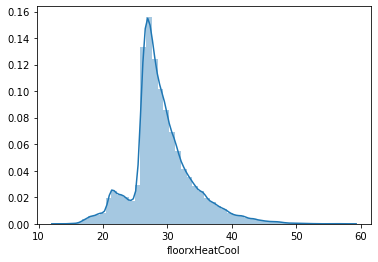

In [129]:
df_t.floorxHeatCool = df_t.floorxHeatCool**(1/6)
sns.distplot(df_t.floorxHeatCool)

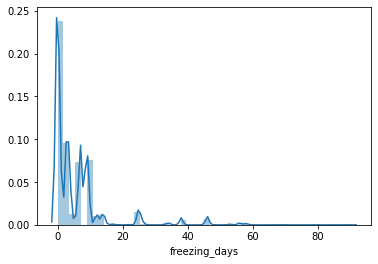

In [130]:
sns.distplot(df_t.freezing_days)

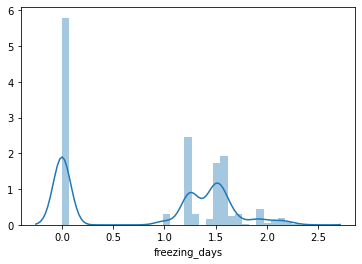

In [131]:
df_t.freezing_days = (df_t.freezing_days)**(1/5)
sns.distplot(df_t.freezing_days)

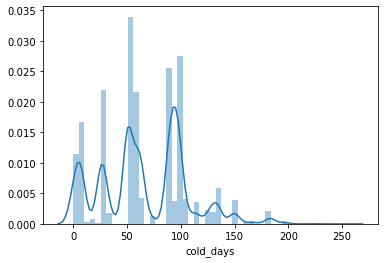

In [132]:
sns.distplot(df_t.cold_days)

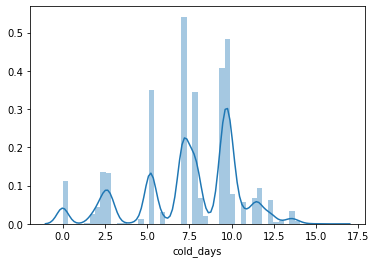

In [133]:
df_t.cold_days = df_t.cold_days**(1/2)
sns.distplot(df_t.cold_days)

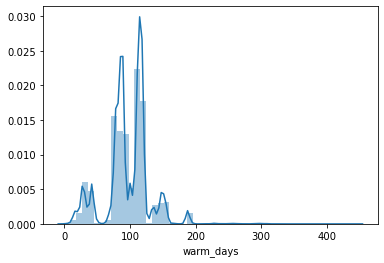

In [134]:
sns.distplot(df_t.warm_days)

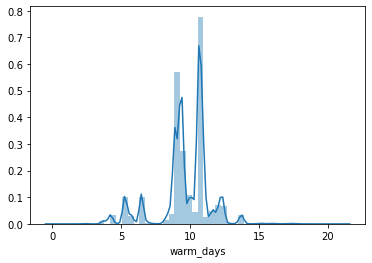

In [135]:
df_t.warm_days = df_t.warm_days**(1/2)
sns.distplot(df_t.warm_days)

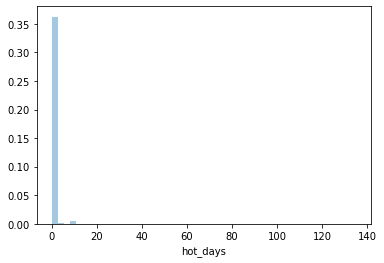

In [136]:
sns.distplot(df_t.hot_days)

In [137]:
df_t = df_t.drop('hot_days',1)

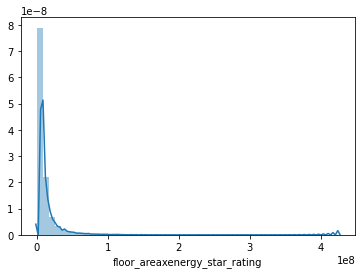

In [138]:
sns.distplot(df_t.floor_areaxenergy_star_rating)

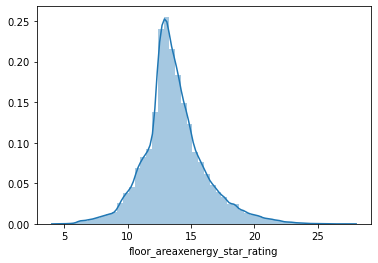

In [139]:
df_t.floor_areaxenergy_star_rating = df_t.floor_areaxenergy_star_rating**(1/6)
sns.distplot(df_t.floor_areaxenergy_star_rating)

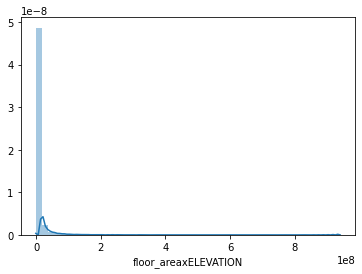

In [140]:
sns.distplot(df_t.floor_areaxELEVATION)

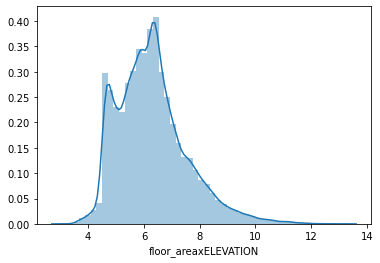

In [141]:
df_t.floor_areaxELEVATION = df_t.floor_areaxELEVATION**(1/8)
sns.distplot(df_t.floor_areaxELEVATION)

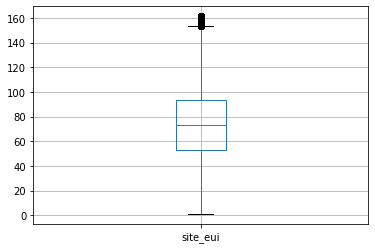

In [142]:
pd.DataFrame(df_t['site_eui']).boxplot()

In [143]:
# for col in X_train.iloc[:,:]:
#     if X_train.loc[:,col].name in numeric:
#         X_train[col] = (X_train[col]- X_train[col].min())/(X_train[col].max()-X_train[col].min())
        
df_t = df_t.fillna(df_t.median())

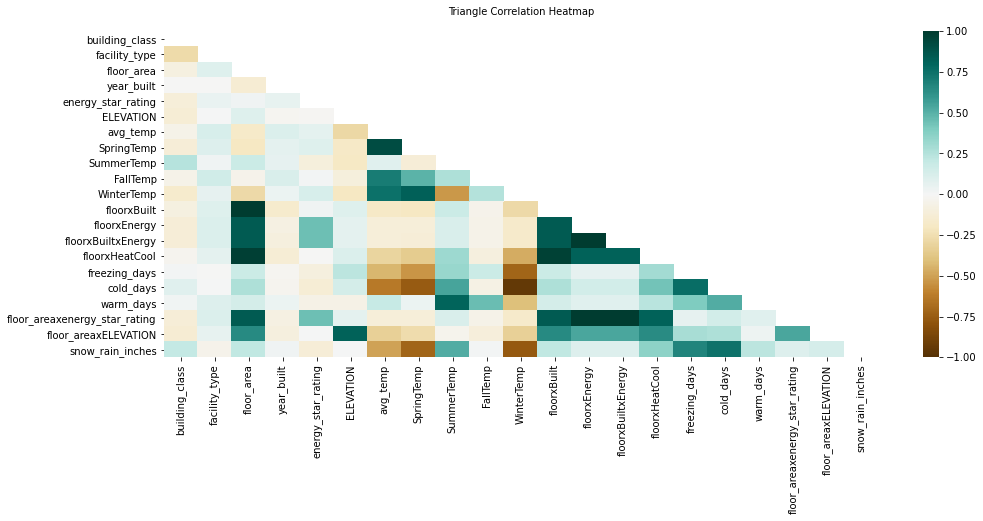

In [144]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_t.drop('site_eui',1).corr(), dtype=np.bool))
heatmap = sns.heatmap(df_t.drop('site_eui',1).corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':10}, pad=16);

In [145]:
df_t = df_t.drop(['floorxBuilt','floorxBuiltxEnergy','floorxHeatCool','floorxEnergy', 'ELEVATION'],1)

In [146]:
from boruta import BorutaPy

forest = RandomForestRegressor(max_depth = 5)
forest.fit(df_t.drop('site_eui',1).values, df_t['site_eui'].values)

# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features
feat_selector.fit(df_t.drop('site_eui',1).values, df_t['site_eui'].values)

# check selected features
feat_selector.support_

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	1
Rejected: 	4
Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	1
Rejected: 	4
Iteration: 	10 / 100
Confirmed: 	11
Tentative: 	1
Rejected: 	4
Iteration: 	11 / 100
Confirmed: 	11
Tentative: 	1
Rejected: 	4
Iteration: 	12 / 100
Confirmed: 	11
Tentative: 	1
Rejected: 	4
Iteration: 	13 / 100
Confirmed: 	11
Tentative: 	1
Rejected: 	4
Iteration: 	14 / 100
Confirmed: 	11
Tentative: 	1
Rejected: 	4
Iteration: 	15 / 100
Confirmed: 	11
Tentative: 	1
Rejected: 	4
Iteration: 	16 / 100
Confirmed: 	11
Tentative: 	1
Rejected: 	4
I

array([ True,  True,  True,  True,  True, False, False, False, False,
        True, False,  True,  True,  True,  True,  True])

In [147]:
# check ranking of features
feat_selector.ranking_

array([1, 1, 1, 1, 1, 4, 5, 2, 3, 1, 5, 1, 1, 1, 1, 1])

In [148]:
selected = df_t.drop('site_eui',1).columns[np.array(feat_selector.support_)]

In [149]:
selected

Index(['building_class', 'facility_type', 'floor_area', 'year_built',
       'energy_star_rating', 'WinterTemp', 'cold_days', 'warm_days',
       'floor_areaxenergy_star_rating', 'floor_areaxELEVATION',
       'snow_rain_inches'],
      dtype='object')

In [150]:
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", df_t.drop('site_eui',1).columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
    else:
        print("Doesn't pass the test: ",
              df_t.drop('site_eui',1).columns[i], " - Ranking: ", feat_selector.ranking_[i])


------Support and Ranking for each feature------
Passes the test:  building_class  - Ranking:  1
Passes the test:  facility_type  - Ranking:  1
Passes the test:  floor_area  - Ranking:  1
Passes the test:  year_built  - Ranking:  1
Passes the test:  energy_star_rating  - Ranking:  1
Doesn't pass the test:  avg_temp  - Ranking:  4
Doesn't pass the test:  SpringTemp  - Ranking:  5
Doesn't pass the test:  SummerTemp  - Ranking:  2
Doesn't pass the test:  FallTemp  - Ranking:  3
Passes the test:  WinterTemp  - Ranking:  1
Doesn't pass the test:  freezing_days  - Ranking:  5
Passes the test:  cold_days  - Ranking:  1
Passes the test:  warm_days  - Ranking:  1
Passes the test:  floor_areaxenergy_star_rating  - Ranking:  1
Passes the test:  floor_areaxELEVATION  - Ranking:  1
Passes the test:  snow_rain_inches  - Ranking:  1


In [151]:
df_selected = df_t.drop('site_eui',1).loc[:,selected]

In [154]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(df_selected)

pca = PCA(n_components = 0.95)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)

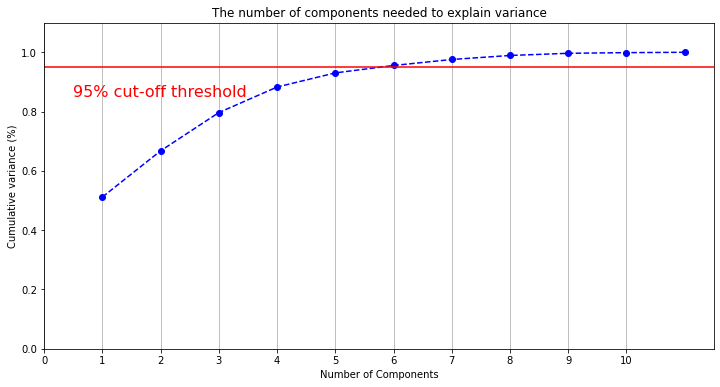

In [155]:
pca = PCA().fit(data_rescaled)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 12, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

[0.51198152 0.15581439 0.12897644 0.08608862 0.0476304  0.02502154
 0.02023654 0.01352929 0.00731891 0.00225123 0.00115112]


Text(0, 0.5, 'Cumulative explained variance')

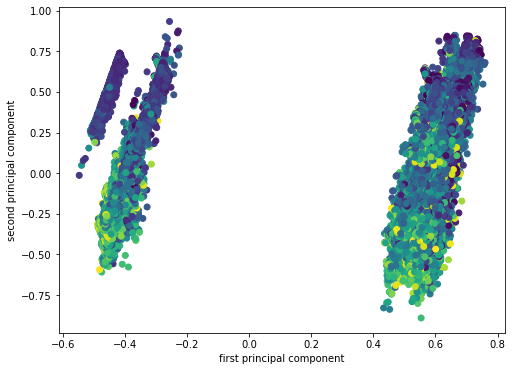

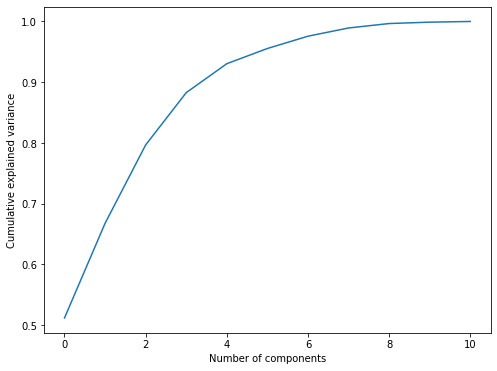

In [156]:
plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0],reduced[:,1], c=df_t['site_eui'])
plt.xlabel('first principal component')
plt.ylabel('second principal component')

print(pca.explained_variance_ratio_)
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

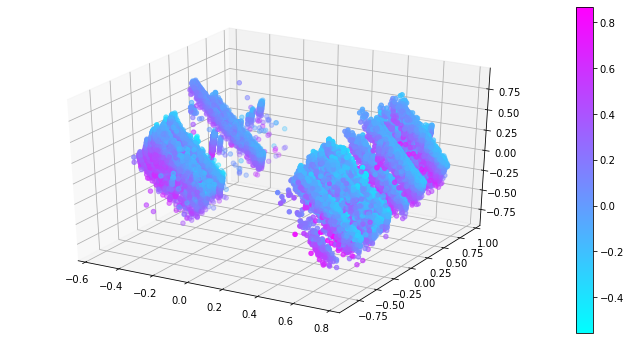

In [157]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = reduced[:,0]
y = reduced[:,1]
z = reduced[:,2]
c = reduced[:,3]
c = reduced[:,4]

img = ax.scatter(x, y, z, c=c, cmap=plt.cool())
fig.colorbar(img)
plt.show()

In [158]:
reduced_df = pd.DataFrame(reduced, columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6'])
reduced_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,0.673080,0.401531,0.486921,-0.284934,0.203749,0.062641
1,0.736811,0.731884,-0.166678,-0.227537,0.115319,0.036930
2,0.570942,0.476286,0.614930,0.378602,0.053110,-0.057842
3,0.731435,0.789403,-0.141452,-0.214078,-0.068550,-0.118990
4,0.689126,0.530186,0.307351,-0.260475,0.069568,0.025571


In [159]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reduced_df, df_t['site_eui'], test_size=0.2, random_state=42)

## Ensembling

In [160]:
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('XGB', XGBRegressor()))
    level0.append(('SVR', SVR()))
    level0.append(('GBR', GradientBoostingRegressor()))
#    level0.append(('CATB', CatBoostRegressor())),
    level0.append(('ElNET', ElasticNet())),
    level0.append(('LGBM', LGBMRegressor()))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=10)
    return model

## Tuning Parameters

In [1925]:
reg0 = ElasticNet(random_state=42)
reg1 = XGBRegressor(random_state=42)
reg2 = SVR()
reg3 = GradientBoostingRegressor(random_state=42)
#reg4 = CatBoostRegressor(random_state=42)
reg5 = LGBMRegressor(random_state=42)
#reg6 = get_stacking()

# Initiaze the hyperparameters for each dictionary

param0 = {}
param0['regressor__max_iter'] = [1,5,10,20,50,100,200,500]
param0['regressor__alpha'] = np.logspace(-5, 5, 100, endpoint=True)
param0['regressor__l1_ratio'] = np.arange(0.0, 1.0, 0.1)
param0['regressor'] = [reg0]

param1 = {}
param1['regressor__n_estimators'] = [50, 100, 250]
param1['regressor__max_depth'] = [3, 6, 10]
param1['regressor__learning_rate'] = [0.01, 0.05, 0.1]
param1['regressor__colsample_bytree']: [0.3, 0.7]
param1['regressor'] = [reg1]

param2 = {}
param2['regressor__kernel'] = ["rbf"]
param2['regressor__C'] = [0.1, 1, 10, 100, 1000]
param2['regressor'] = [reg2]

param3 = {}
param3['regressor__max_depth'] = [3,4,5]
param3['regressor__n_estimators'] = [100, 200, 300]
param3['regressor__learning_rate'] = [0.01, 0.05, 0.1]
param3['regressor'] = [reg3]

# param4 = {}
# param4['regressor__n_estimators'] = [100,200,500]
# param4['regressor__learning_rate'] = [.001,0.01,.1]
# param4['regressor__max_depth'] = [1,2,4]
# param4['regressor'] = [reg4]

param5 = {}
param5['regressor__num_leaves'] = [200,300,500, 800]
param5['regressor__learning_rate'] = [.001,0.01,.1, 0.05]
param5['regressor__feature_fraction'] = [0.3,0.6,0.9, 1]
param5['regressor__bagging_freq'] = [30, 50,70,90, 100]
param5['regressor'] = [reg5]

params = [param1, param2, param3, param5]

def tune(reg, param):
    pipeline = Pipeline([('regressor', reg)])
    rs = RandomizedSearchCV(pipeline, param, cv=5, scoring='neg_mean_squared_error')
    rs.fit(X_train, y_train)
    return rs.best_params_, rs.best_score_

In [1926]:
tune(reg0, param0)

({'regressor__max_iter': 5,
  'regressor__l1_ratio': 0.8,
  'regressor__alpha': 6.428073117284319e-05,
  'regressor': ElasticNet(alpha=6.428073117284319e-05, l1_ratio=0.8, max_iter=5,
             random_state=42)},
 -690.6802946960167)

In [1927]:
tune(reg1, param1)

({'regressor__n_estimators': 100,
  'regressor__max_depth': 10,
  'regressor__learning_rate': 0.05,
  'regressor': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.05, max_delta_step=None, max_depth=10,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=42, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None)},
 -568.1629192836531)

In [1928]:
tune(reg2, param2)

({'regressor__kernel': 'rbf', 'regressor__C': 1000, 'regressor': SVR(C=1000)},
 -579.4040703870844)

In [1929]:
tune(reg3, param3)

({'regressor__n_estimators': 200,
  'regressor__max_depth': 5,
  'regressor__learning_rate': 0.05,
  'regressor': GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=200,
                            random_state=42)},
 -573.6821118542673)

In [1930]:
tune(reg5, param5)

[LightGBM] [Warning] bagging_freq is set=70, subsample_freq=0 will be ignored. Current value: bagging_freq=70
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=70, subsample_freq=0 will be ignored. Current value: bagging_freq=70
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=70, subsample_freq=0 will be ignored. Current value: bagging_freq=70
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=70, subsample_freq=0 will be ignored. Current value: bagging_freq=70
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=70, subsample_freq=0 will be ignored. C

({'regressor__num_leaves': 300,
  'regressor__learning_rate': 0.05,
  'regressor__feature_fraction': 1,
  'regressor__bagging_freq': 100,
  'regressor': LGBMRegressor(bagging_freq=100, feature_fraction=1, learning_rate=0.05,
                num_leaves=300, random_state=42)},
 -565.3831769451674)

## Model Validation

In [161]:
def run_exps(X_train, y_train, X_test, y_test) -> pd.DataFrame:
    
    dfs = []
    models = [
         ('Stack', get_stacking()),
          ('XGB', XGBRegressor(n_estimators = 100, max_depth = 10, learning_rate = 0.05)), 
          ('LGBM', LGBMRegressor(num_leaves = 300, feature_fraction = 1, bagging_freq = 100, learning = 0.05)),
          ('GBR', GradientBoostingRegressor(n_estimators = 200, max_depth = 5,learning_rate=0.05)),
          ('SVR', SVR(C = 1000)),
          ('ElNet', ElasticNet(alpha=6.428073117284319e-05, l1_ratio=0.8, max_iter=5))
#          ('CATB', CatBoostRegressor(n_estimators = 500, max_depth = 4, learning_rate = 0.1)),)
          ]
    results = []
    names = []
    scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

    for name, model in models:
        kfold = model_selection.RepeatedKFold(n_splits=5, n_repeats = 3, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        f = 'models/{}.sav'.format(name)
        pickle.dump(model, open(f, 'wb'))
        y_pred = clf.predict(X_test)
        print(name)
        print(mean_squared_error(y_test, y_pred, squared = False))
        
        results.append(cv_results)
        names.append(name)

        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)

        final = pd.concat(dfs, ignore_index=True)
        

    return final

In [162]:
%%time
import os  
final = run_exps(X_train, y_train, X_test, y_test)

Stack
23.87745596820852
XGB
23.88521840491415
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytr

| **Model** | **RMSE** |
|---|---|
| Light Gradient Boosting Regressor | 24.0045 |
| Gradient Boosting Regressor | 24.0235 |
| Support Vector Regressor (Radial) | 24.1036 |
| XGBoost Regressor | 23.8852 |
| Elastic Net | 26.2607 |
| Stacked Ensemble |23.8775  |

In [163]:
final.to_csv('models/out.csv')  

In [164]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=50, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

In [181]:
metric_df = results_long_nofit[results_long_nofit.metrics == 'test_neg_mean_squared_error']
metric_df['values'] = (metric_df['values']*(-1))**(1/2)

Text(0.5, 1.0, 'Comparison of Model by different metrics')

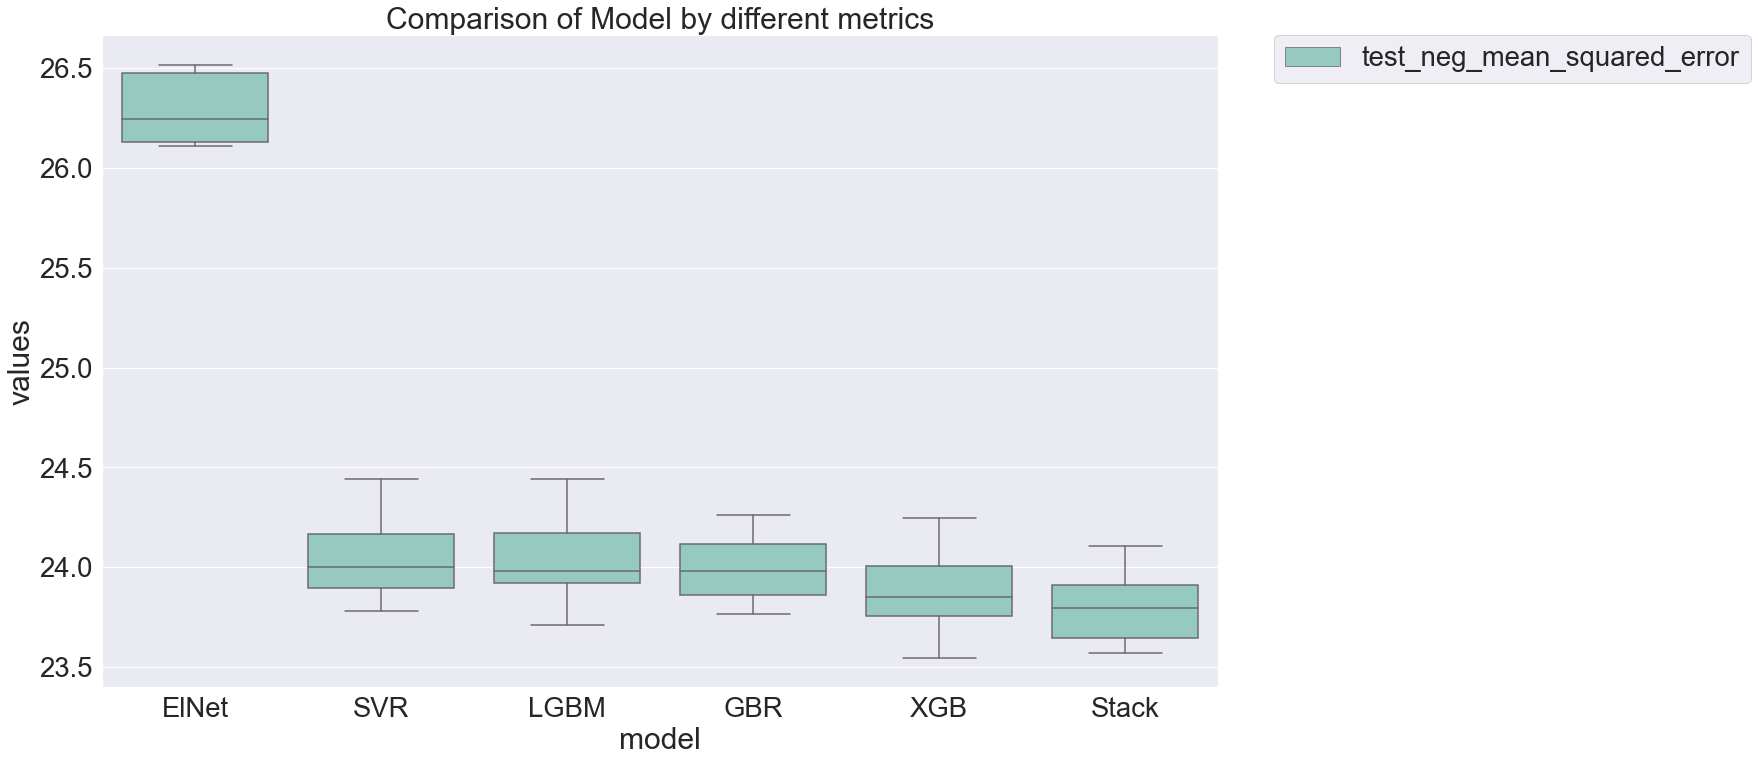

In [182]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=metric_df, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by different metrics')
#plt.savefig('./benchmark_models_performance.png',dpi=300)

In [184]:
metric_df = results_long_nofit[results_long_nofit.metrics == 'test_r2']

Text(0.5, 1.0, 'Comparison of Model by different metrics')

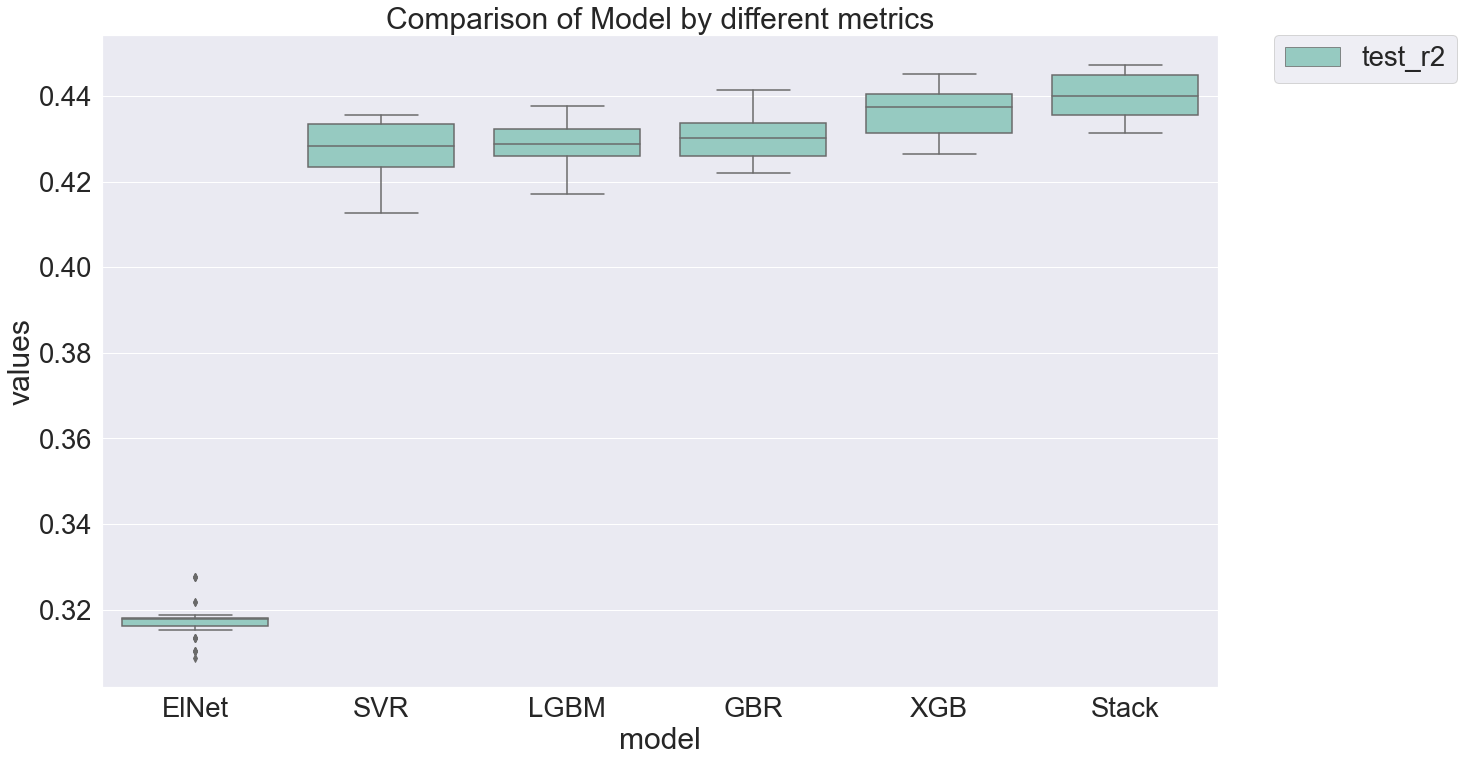

In [185]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=metric_df, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by different metrics')
#plt.savefig('./benchmark_models_performance.png',dpi=300)

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

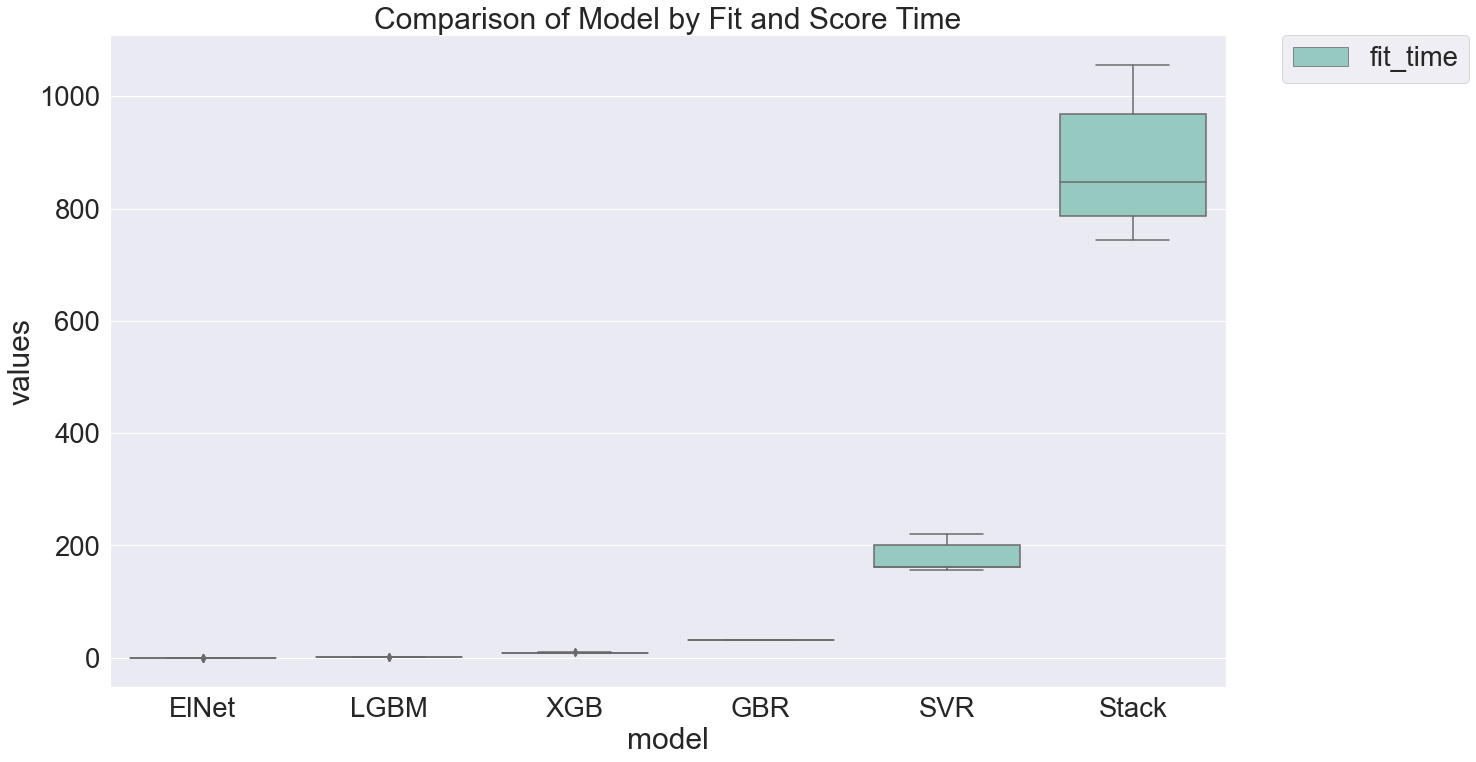

In [187]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit[results_long_fit.metrics =='fit_time'], palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

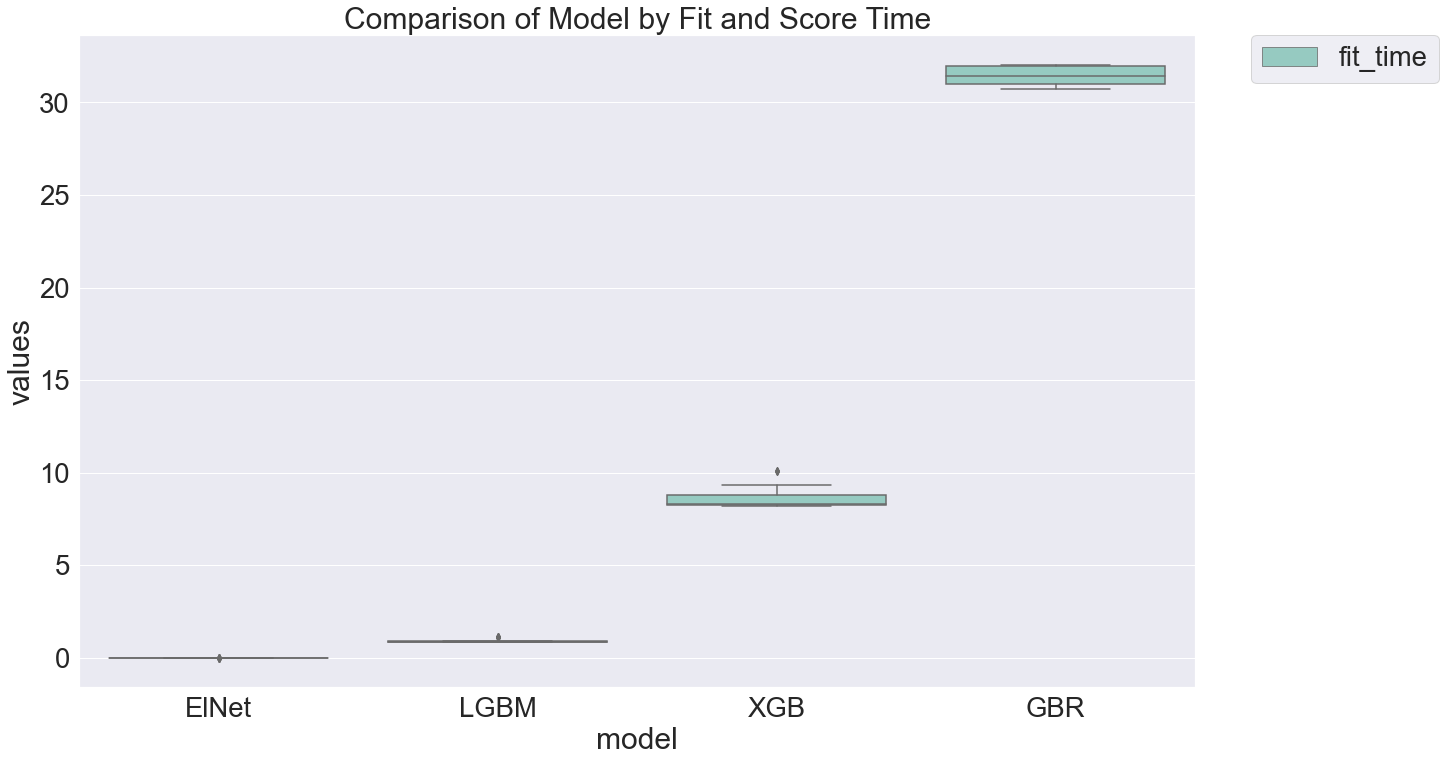

In [193]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit[(results_long_fit.metrics =='fit_time') & 
                                                                            (results_long_fit.model != 'Stack') &
                                                                           (results_long_fit.model != 'SVR')], palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

In [197]:
metric_df['values'] = (metric_df['values']*(-1))**(1/2)
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_neg_mean_absolute_error              test_r2            \
                               std       mean       std      mean   
model                                                               
ElNet                     0.106032 -19.725016  0.004125  0.317173   
GBR                       0.086909 -17.337245  0.005551  0.430776   
LGBM                      0.113151 -17.130865  0.004803  0.428644   
SVR                       0.122487 -16.943193  0.005974  0.427390   
Stack                     0.102187 -17.107605  0.004987  0.440123   
XGB                       0.107978 -17.084536  0.005570  0.436127   

      test_neg_mean_squared_error              
                              std        mean  
model                                          
ElNet                    7.791188 -690.434528  
GBR                      7.757110 -576.018759  
LGBM                     8.195327 -577.143635  
SVR                      9.757870 -578.136134  
Stack                    7.785594 -566.479391  
XGB                      8.303589 -570.192122

In [198]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

fit_time             score_time          
              std        mean        std      mean
model                                             
ElNet    0.001044    0.008041   0.000409  0.002809
GBR      0.473420   31.438220   0.001777  0.043999
LGBM     0.095794    0.895086   0.002957  0.069958
SVR     23.194957  176.095949   1.180131  9.124298
Stack  103.264619  877.009844   1.237362  8.806448
XGB      0.510448    8.541819   0.002622  0.020216

In [256]:
GBR = pickle.load(open('models/GBR.sav', 'rb'))
LGBM = pickle.load(open('models/LGBM.sav', 'rb'))
Stack = pickle.load(open('models/Stack.sav', 'rb'))
SVR = pickle.load(open('models/SVR.sav', 'rb'))
XGB = pickle.load(open('models/XGB.sav', 'rb'))
ElNet = pickle.load(open('models/ElNet.sav', 'rb'))

## Predictions

In [267]:
from nonconformist.cp import IcpRegressor
from nonconformist.cp import IcpClassifier
from nonconformist.nc import NcFactory

train_percentage = 0.8
cal_percentage = 0.2
n_total = X_train.shape[0]
n_train = int(train_percentage*n_total)
n_cal = int(cal_percentage*n_total) + n_train
train_data = X_train.iloc[:n_train, :]
train_target = y_train.iloc[:n_train]
cal_data = X_train.iloc[n_train:n_cal, :]
cal_target = y_train.iloc[n_train:n_cal]
test_data = X_test
test_target = y_test

In [268]:
def PI(model, level1, level2):
    
    # Default nonconformity measure
    nc = NcFactory.create_nc(model)
    # Inductive conformal regressor
    icp = IcpRegressor(nc)
    # Fit the ICP using the proper training set
    icp.fit(train_data.values, train_target.values)
    # Calibrate the ICP using the calibration set
    icp.calibrate(cal_data.values, cal_target.values)

    # Produce predictions for the test set
    prediction1 = icp.predict(test_data.values, significance=(1-level1))
    lower_1 = prediction1[:, 0]
    upper_1 = prediction1[:, 1]

    prediction2 = icp.predict(test_data.values, significance=(1-level2))
    lower_2 = prediction2[:, 0]
    upper_2 = prediction2[:, 1]

    df_50 = pd.DataFrame()
    df_80 = pd.DataFrame()
    df_50 = df_50.append(pd.DataFrame({'pred': model.predict(test_data.values),
                      'LB': lower_1,
                      'UB': upper_1}
                     ))
    
    df_80 = df_80.append(pd.DataFrame({'pred': model.predict(test_data.values),
                      'LB': lower_2,
                      'UB': upper_2}
                     ))
        
    return df_50, df_80

In [269]:
%%time
PI_LGBM = PI(LGBM,0.5,0.8)

[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
CPU times: user 5.85 s, sys: 131 ms, total: 5.99 s
Wall time: 2.35 s


In [270]:
%%time
PI_SVR = PI(SVR,0.5,0.8)

CPU times: user 4min 36s, sys: 4.51 s, total: 4min 41s
Wall time: 5min 13s


In [271]:
%%time
PI_ElNet = PI(ElNet,0.5,0.8)

CPU times: user 224 ms, sys: 34.7 ms, total: 258 ms
Wall time: 361 ms


In [272]:
%%time
PI_GBR = PI(GBR,0.5,0.8)

CPU times: user 44.3 s, sys: 667 ms, total: 44.9 s
Wall time: 47.1 s


In [273]:
%%time
PI_XGB = PI(XGB,0.5,0.8)

CPU times: user 33.5 s, sys: 724 ms, total: 34.2 s
Wall time: 12.5 s


In [274]:
%%time
PI_Stack = PI(Stack, 0.5,0.8)

CPU times: user 19min 23s, sys: 19.1 s, total: 19min 42s
Wall time: 18min 11s


In [289]:
def intervalScore(predObj,actual,level):
    n = len(predObj)
    alpha = 1 - level
    upper = predObj.loc[:,'UB']
    lower = predObj.loc[:,'LB']
    ilow = (actual.values<lower)
    ihigh = (actual.values>upper)
    sumlength = sum(upper-lower)
    sumlow = sum(predObj.loc[ilow,'LB']-actual.values[ilow])*2/alpha
    sumhigh = sum(actual.values[ihigh]-predObj.loc[ihigh,'UB'])*2/alpha
    avglength = sumlength/n
    IS = (sumlength+sumlow+sumhigh)/n # average length + average under/over penalties
    cover = ((actual.values>= lower) & (actual.values<=upper)).mean()
    summ = pd.DataFrame(np.array([[level,avglength,IS,cover]]), columns = ['level','avglength', 'IS', 'cover'])
    return summ

In [308]:
intervalScore(PI_LGBM[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,23.675021,58.053079,0.493913


In [309]:
intervalScore(PI_LGBM[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,54.604375,89.739934,0.79847


In [306]:
intervalScore(PI_GBR[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,24.705315,58.114026,0.506226


In [307]:
intervalScore(PI_GBR[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,54.755009,89.174804,0.794643


In [304]:
intervalScore(PI_XGB[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,23.855599,57.693341,0.504765


In [305]:
intervalScore(PI_XGB[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,54.164624,89.305558,0.799235


In [302]:
intervalScore(PI_ElNet[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,29.155639,65.155167,0.50087


In [303]:
intervalScore(PI_ElNet[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,64.46488,96.675231,0.798817


In [300]:
intervalScore(PI_SVR[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,23.266499,57.622133,0.502122


In [301]:
intervalScore(PI_SVR[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,53.119757,89.999751,0.792765


In [298]:
intervalScore(PI_Stack[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,24.337802,57.656382,0.505113


In [299]:
intervalScore(PI_Stack[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,54.447974,88.648392,0.797287


| **Model** | **Level** | **Avg Length** | **IS** | **Coverage** | |
|---|---|---|---|---|---|
| LGBM | 0.5|23.675021|58.053079|0.493913 | |
| SVR | 0.5  | 23.266499  | 57.622133 | 0.502122 | |
| GBR | 0.5|24.705315|58.114026|0.506226 | |
|Elnet| 0.5|29.155639|65.155167|0.50087| |
| XGB | 0.5|23.855599|57.693341|0.504765 | |
| Stack | 0.5 | 24.337802 | 57.656382 |0.505113 | * |

| **Model** | **Level** | **Avg Length** | **IS** | **Coverage** | |
|---|---|---|---|---|---|
| LGBM | 0.8|54.604375|89.739934|0.79847 | |
| SVR | 0.8 | 53.119757 | 89.999751 | 0.792765 | |
| GBR | 0.8|54.755009|89.174804|0.794643 | |
|ElNet| 0.8|64.46488|96.675231|0.798817 | |
| XGB | 0.8|54.164624|89.305558|0.7992355 | |
| Stack | 0.8 | 54.447974 | 88.648392 |0.797287|* |

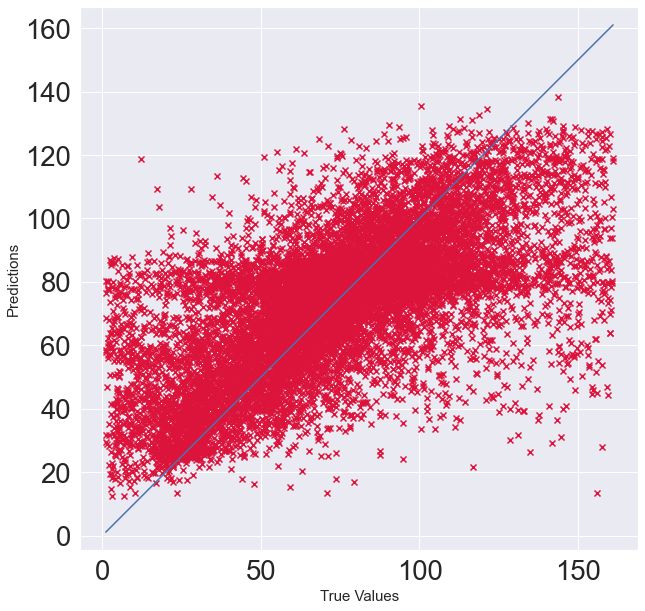

In [338]:
plt.figure(figsize=(10,10))
plt.scatter(test_target, PI_Stack[0].iloc[:,0], c='crimson',marker = 'x')

p1 = max(max(PI_Stack[0].iloc[:,0]), max(test_target))
p2 = min(min(PI_Stack[0].iloc[:,0]), min(test_target))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()